In [22]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from copy import deepcopy as copy
from torch.utils.data import DataLoader, TensorDataset
sns.set()
def seed_torch(seed=1122):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch()

# Loading the data

In [3]:
sh02 = pd.read_csv('history_sh.000002_stock_k_data.csv')
sh02.drop(['code','preclose','amount','adjustflag','turn','tradestatus','pctChg','isST'], axis=1, inplace=True)
sh02 = sh02.set_index('date')
sh02.head()

,open,high,low,close,volume
date,,,,,
2016-01-04,3701.584,3703.778,3449.499,3450.031,18281590784
2016-01-05,3345.625,3483.121,3338.100,3440.785,26481264384
2016-01-06,3444.441,3519.729,3442.200,3518.541,23725938688
2016-01-07,3463.891,3463.891,3261.164,3270.706,7008106496
2016-01-08,3343.442,3386.281,3199.253,3334.934,28444573440


In [4]:
class GetData:
    def __init__(self, batch_size=20, n=5):
        self.data = sh02
        self.batch_size = batch_size
        self.n = n
        
    def getData(self):
        self.close_min = self.data['close'].min()
        self.close_max = self.data["close"].max()
        self.data = self.data.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
        return self.data
    
    def process_data(self):
        n = self.n
        self.getData()
        feature = [
            self.data.iloc[i: i + n].values.tolist()
            for i in range(len(self.data) - n + 2)
            if i + n < len(self.data)
        ]
        label = [
            self.data.close.values[i + n]
            for i in range(len(self.data) - n + 2)
            if i + n < len(self.data)
        ]
        num = int(len(feature) * 0.9)
        train_x = feature[:num]
        test_x = feature[num:]
        train_y = label[:num]
        test_y = label[num:]
        return train_x, test_x, train_y, test_y
    
    def get_dataloader(self):
        batch_size = self.batch_size
        train_x, test_x, train_y, test_y = self.process_data()
        x_train = torch.tensor(train_x).float()
        x_test = torch.tensor(test_x).float()
        y_train = torch.tensor(train_y).float()
        y_test = torch.tensor(test_y).float()
        train_data = TensorDataset(x_train, y_train)
        train_dataLoader = DataLoader(train_data, batch_size=batch_size)
        test_data = TensorDataset(x_test, y_test)
        test_dataLoader = DataLoader(test_data, batch_size=batch_size)
        return train_data, test_data

In [67]:
GD = GetData()
train_x, test_x, train_y, test_y = GD.process_data()

In [68]:
x_train = torch.tensor(train_x).float()
x_test = torch.tensor(test_x).float()
y_train = torch.tensor(train_y).float()
y_test = torch.tensor(test_y).float()

In [69]:
y_train

tensor([0.4461, 0.4510, 0.3916,  ..., 0.6614, 0.6751, 0.6656])

In [70]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([1143, 5, 5])
torch.Size([127, 5, 5])
torch.Size([1143])
torch.Size([127])


In [7]:
batch_size = 20
train_data = TensorDataset(x_train, y_train)
train_dataLoader = DataLoader(train_data, batch_size=batch_size)
test_data = TensorDataset(x_test, y_test)
test_dataLoader = DataLoader(test_data, batch_size=batch_size)

In [38]:
for x, y in train_data:
    print(x)
    print(x.shape)
    print(y.shape)

tensor([[0.8513, 0.8407, 0.6956, 0.6719, 0.1921],
        [0.5856, 0.6717, 0.6089, 0.6648, 0.3318],
        [0.6593, 0.6998, 0.6899, 0.7249, 0.2849],
        [0.6739, 0.6570, 0.5490, 0.5334, 0.0000],
        [0.5839, 0.5976, 0.5008, 0.5830, 0.3653]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5856, 0.6717, 0.6089, 0.6648, 0.3318],
        [0.6593, 0.6998, 0.6899, 0.7249, 0.2849],
        [0.6739, 0.6570, 0.5490, 0.5334, 0.0000],
        [0.5839, 0.5976, 0.5008, 0.5830, 0.3653],
        [0.5349, 0.5422, 0.4685, 0.4461, 0.3397]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6593, 0.6998, 0.6899, 0.7249, 0.2849],
        [0.6739, 0.6570, 0.5490, 0.5334, 0.0000],
        [0.5839, 0.5976, 0.5008, 0.5830, 0.3653],
        [0.5349, 0.5422, 0.4685, 0.4461, 0.3397],
        [0.4527, 0.4473, 0.4373, 0.4510, 0.2324]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6739, 0.6570, 0.5490, 0.5334, 0.0000],
        [0.5839, 0.5976, 0.5008, 0.5830, 0.3653],
        [0.5349, 0.5422, 0.4685, 0.4461, 0.33

        [0.4628, 0.4566, 0.4780, 0.4730, 0.2753]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4390, 0.4274, 0.4485, 0.4351, 0.2551],
        [0.4294, 0.4164, 0.4186, 0.4397, 0.2314],
        [0.4324, 0.4547, 0.4487, 0.4750, 0.3168],
        [0.4628, 0.4566, 0.4780, 0.4730, 0.2753],
        [0.4773, 0.4587, 0.4600, 0.4388, 0.2559]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4294, 0.4164, 0.4186, 0.4397, 0.2314],
        [0.4324, 0.4547, 0.4487, 0.4750, 0.3168],
        [0.4628, 0.4566, 0.4780, 0.4730, 0.2753],
        [0.4773, 0.4587, 0.4600, 0.4388, 0.2559],
        [0.4224, 0.4056, 0.4220, 0.4198, 0.1996]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4324, 0.4547, 0.4487, 0.4750, 0.3168],
        [0.4628, 0.4566, 0.4780, 0.4730, 0.2753],
        [0.4773, 0.4587, 0.4600, 0.4388, 0.2559],
        [0.4224, 0.4056, 0.4220, 0.4198, 0.1996],
        [0.4371, 0.4480, 0.4600, 0.4595, 0.2545]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4628, 0.4566, 0.4780, 0.4730, 0.2753],
        [0

        [0.2974, 0.2710, 0.2764, 0.2765, 0.1189]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2977, 0.2886, 0.3029, 0.2923, 0.0749],
        [0.2886, 0.2896, 0.2955, 0.3115, 0.0755],
        [0.3153, 0.2969, 0.3179, 0.3057, 0.0904],
        [0.2974, 0.2710, 0.2764, 0.2765, 0.1189],
        [0.2774, 0.2722, 0.2928, 0.2763, 0.0700]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2886, 0.2896, 0.2955, 0.3115, 0.0755],
        [0.3153, 0.2969, 0.3179, 0.3057, 0.0904],
        [0.2974, 0.2710, 0.2764, 0.2765, 0.1189],
        [0.2774, 0.2722, 0.2928, 0.2763, 0.0700],
        [0.2703, 0.2697, 0.2796, 0.2913, 0.0651]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3153, 0.2969, 0.3179, 0.3057, 0.0904],
        [0.2974, 0.2710, 0.2764, 0.2765, 0.1189],
        [0.2774, 0.2722, 0.2928, 0.2763, 0.0700],
        [0.2703, 0.2697, 0.2796, 0.2913, 0.0651],
        [0.2964, 0.2873, 0.3132, 0.3060, 0.0854]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2974, 0.2710, 0.2764, 0.2765, 0.1189],
        [0

        [0.3787, 0.3596, 0.3915, 0.3756, 0.1433]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3076, 0.3256, 0.3246, 0.3481, 0.1469],
        [0.3423, 0.3399, 0.3561, 0.3618, 0.1761],
        [0.3685, 0.3563, 0.3856, 0.3772, 0.2091],
        [0.3787, 0.3596, 0.3915, 0.3756, 0.1433],
        [0.3789, 0.3651, 0.3944, 0.3779, 0.1208]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3423, 0.3399, 0.3561, 0.3618, 0.1761],
        [0.3685, 0.3563, 0.3856, 0.3772, 0.2091],
        [0.3787, 0.3596, 0.3915, 0.3756, 0.1433],
        [0.3789, 0.3651, 0.3944, 0.3779, 0.1208],
        [0.3730, 0.4032, 0.3917, 0.4234, 0.2579]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3685, 0.3563, 0.3856, 0.3772, 0.2091],
        [0.3787, 0.3596, 0.3915, 0.3756, 0.1433],
        [0.3789, 0.3651, 0.3944, 0.3779, 0.1208],
        [0.3730, 0.4032, 0.3917, 0.4234, 0.2579],
        [0.4258, 0.4175, 0.4473, 0.4378, 0.2806]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3787, 0.3596, 0.3915, 0.3756, 0.1433],
        [0

        [0.4508, 0.4361, 0.4691, 0.4480, 0.1608]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4159, 0.4028, 0.4319, 0.4139, 0.1219],
        [0.4110, 0.4132, 0.4217, 0.4363, 0.1454],
        [0.4335, 0.4302, 0.4540, 0.4536, 0.1698],
        [0.4508, 0.4361, 0.4691, 0.4480, 0.1608],
        [0.4432, 0.4400, 0.4561, 0.4350, 0.1560]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4110, 0.4132, 0.4217, 0.4363, 0.1454],
        [0.4335, 0.4302, 0.4540, 0.4536, 0.1698],
        [0.4508, 0.4361, 0.4691, 0.4480, 0.1608],
        [0.4432, 0.4400, 0.4561, 0.4350, 0.1560],
        [0.4327, 0.4505, 0.4544, 0.4739, 0.1668]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4335, 0.4302, 0.4540, 0.4536, 0.1698],
        [0.4508, 0.4361, 0.4691, 0.4480, 0.1608],
        [0.4432, 0.4400, 0.4561, 0.4350, 0.1560],
        [0.4327, 0.4505, 0.4544, 0.4739, 0.1668],
        [0.4768, 0.5198, 0.4991, 0.5342, 0.3865]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4508, 0.4361, 0.4691, 0.4480, 0.1608],
        [0

        [0.4624, 0.4530, 0.4836, 0.4669, 0.1174]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4365, 0.4307, 0.4593, 0.4537, 0.0834],
        [0.4536, 0.4316, 0.4679, 0.4513, 0.0829],
        [0.4492, 0.4353, 0.4693, 0.4536, 0.0774],
        [0.4624, 0.4530, 0.4836, 0.4669, 0.1174],
        [0.4674, 0.4468, 0.4817, 0.4601, 0.0938]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4536, 0.4316, 0.4679, 0.4513, 0.0829],
        [0.4492, 0.4353, 0.4693, 0.4536, 0.0774],
        [0.4624, 0.4530, 0.4836, 0.4669, 0.1174],
        [0.4674, 0.4468, 0.4817, 0.4601, 0.0938],
        [0.4544, 0.4320, 0.4388, 0.4168, 0.1257]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4492, 0.4353, 0.4693, 0.4536, 0.0774],
        [0.4624, 0.4530, 0.4836, 0.4669, 0.1174],
        [0.4674, 0.4468, 0.4817, 0.4601, 0.0938],
        [0.4544, 0.4320, 0.4388, 0.4168, 0.1257],
        [0.4125, 0.4079, 0.4298, 0.4312, 0.0874]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4624, 0.4530, 0.4836, 0.4669, 0.1174],
        [0

        [0.5470, 0.5277, 0.5345, 0.5371, 0.2907]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5316, 0.5231, 0.5529, 0.5346, 0.2168],
        [0.5305, 0.5214, 0.5510, 0.5411, 0.1858],
        [0.5430, 0.5356, 0.5655, 0.5529, 0.2051],
        [0.5470, 0.5277, 0.5345, 0.5371, 0.2907],
        [0.5490, 0.5480, 0.5767, 0.5718, 0.2957]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5305, 0.5214, 0.5510, 0.5411, 0.1858],
        [0.5430, 0.5356, 0.5655, 0.5529, 0.2051],
        [0.5470, 0.5277, 0.5345, 0.5371, 0.2907],
        [0.5490, 0.5480, 0.5767, 0.5718, 0.2957],
        [0.5653, 0.5724, 0.5909, 0.5918, 0.4091]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5430, 0.5356, 0.5655, 0.5529, 0.2051],
        [0.5470, 0.5277, 0.5345, 0.5371, 0.2907],
        [0.5490, 0.5480, 0.5767, 0.5718, 0.2957],
        [0.5653, 0.5724, 0.5909, 0.5918, 0.4091],
        [0.5796, 0.5874, 0.6078, 0.6034, 0.4412]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5470, 0.5277, 0.5345, 0.5371, 0.2907],
        [0

        [0.5234, 0.5036, 0.5246, 0.5164, 0.1484]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5312, 0.5211, 0.5377, 0.5284, 0.2036],
        [0.5200, 0.5131, 0.5421, 0.5326, 0.1610],
        [0.5271, 0.5102, 0.5452, 0.5287, 0.1426],
        [0.5234, 0.5036, 0.5246, 0.5164, 0.1484],
        [0.5167, 0.5224, 0.5430, 0.5445, 0.1983]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5200, 0.5131, 0.5421, 0.5326, 0.1610],
        [0.5271, 0.5102, 0.5452, 0.5287, 0.1426],
        [0.5234, 0.5036, 0.5246, 0.5164, 0.1484],
        [0.5167, 0.5224, 0.5430, 0.5445, 0.1983],
        [0.5362, 0.5247, 0.5590, 0.5461, 0.1659]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5271, 0.5102, 0.5452, 0.5287, 0.1426],
        [0.5234, 0.5036, 0.5246, 0.5164, 0.1484],
        [0.5167, 0.5224, 0.5430, 0.5445, 0.1983],
        [0.5362, 0.5247, 0.5590, 0.5461, 0.1659],
        [0.5383, 0.5208, 0.5401, 0.5223, 0.1632]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5234, 0.5036, 0.5246, 0.5164, 0.1484],
        [0

        [0.5538, 0.5380, 0.5699, 0.5573, 0.0990]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5497, 0.5409, 0.5772, 0.5622, 0.0742],
        [0.5582, 0.5405, 0.5667, 0.5469, 0.0373],
        [0.5450, 0.5375, 0.5662, 0.5605, 0.0970],
        [0.5538, 0.5380, 0.5699, 0.5573, 0.0990],
        [0.5489, 0.5444, 0.5634, 0.5686, 0.1271]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5582, 0.5405, 0.5667, 0.5469, 0.0373],
        [0.5450, 0.5375, 0.5662, 0.5605, 0.0970],
        [0.5538, 0.5380, 0.5699, 0.5573, 0.0990],
        [0.5489, 0.5444, 0.5634, 0.5686, 0.1271],
        [0.5619, 0.5599, 0.5883, 0.5817, 0.2066]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5450, 0.5375, 0.5662, 0.5605, 0.0970],
        [0.5538, 0.5380, 0.5699, 0.5573, 0.0990],
        [0.5489, 0.5444, 0.5634, 0.5686, 0.1271],
        [0.5619, 0.5599, 0.5883, 0.5817, 0.2066],
        [0.5762, 0.5745, 0.6048, 0.5926, 0.2877]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5538, 0.5380, 0.5699, 0.5573, 0.0990],
        [0

        [0.6215, 0.6114, 0.6417, 0.6364, 0.1708]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6171, 0.6055, 0.6414, 0.6291, 0.1255],
        [0.6263, 0.6264, 0.6573, 0.6511, 0.2027],
        [0.6456, 0.6299, 0.6451, 0.6255, 0.2217],
        [0.6215, 0.6114, 0.6417, 0.6364, 0.1708],
        [0.6287, 0.6203, 0.6568, 0.6451, 0.1575]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6263, 0.6264, 0.6573, 0.6511, 0.2027],
        [0.6456, 0.6299, 0.6451, 0.6255, 0.2217],
        [0.6215, 0.6114, 0.6417, 0.6364, 0.1708],
        [0.6287, 0.6203, 0.6568, 0.6451, 0.1575],
        [0.6255, 0.6151, 0.6425, 0.6318, 0.2032]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6456, 0.6299, 0.6451, 0.6255, 0.2217],
        [0.6215, 0.6114, 0.6417, 0.6364, 0.1708],
        [0.6287, 0.6203, 0.6568, 0.6451, 0.1575],
        [0.6255, 0.6151, 0.6425, 0.6318, 0.2032],
        [0.6252, 0.6202, 0.6369, 0.6347, 0.2075]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6215, 0.6114, 0.6417, 0.6364, 0.1708],
        [0

        [0.5413, 0.5291, 0.5567, 0.5430, 0.1593]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5358, 0.5344, 0.5351, 0.5566, 0.2409],
        [0.5457, 0.5342, 0.5672, 0.5587, 0.1578],
        [0.5483, 0.5343, 0.5672, 0.5498, 0.1430],
        [0.5413, 0.5291, 0.5567, 0.5430, 0.1593],
        [0.5325, 0.5254, 0.5466, 0.5365, 0.1835]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5457, 0.5342, 0.5672, 0.5587, 0.1578],
        [0.5483, 0.5343, 0.5672, 0.5498, 0.1430],
        [0.5413, 0.5291, 0.5567, 0.5430, 0.1593],
        [0.5325, 0.5254, 0.5466, 0.5365, 0.1835],
        [0.5228, 0.5044, 0.5309, 0.5169, 0.1801]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5483, 0.5343, 0.5672, 0.5498, 0.1430],
        [0.5413, 0.5291, 0.5567, 0.5430, 0.1593],
        [0.5325, 0.5254, 0.5466, 0.5365, 0.1835],
        [0.5228, 0.5044, 0.5309, 0.5169, 0.1801],
        [0.5036, 0.4851, 0.5110, 0.4972, 0.1876]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5413, 0.5291, 0.5567, 0.5430, 0.1593],
        [0

        [0.5316, 0.5208, 0.5516, 0.5410, 0.1307]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5503, 0.5427, 0.5665, 0.5470, 0.1303],
        [0.5382, 0.5355, 0.5630, 0.5582, 0.0989],
        [0.5482, 0.5301, 0.5583, 0.5396, 0.1159],
        [0.5316, 0.5208, 0.5516, 0.5410, 0.1307],
        [0.5322, 0.5180, 0.5522, 0.5334, 0.1011]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5382, 0.5355, 0.5630, 0.5582, 0.0989],
        [0.5482, 0.5301, 0.5583, 0.5396, 0.1159],
        [0.5316, 0.5208, 0.5516, 0.5410, 0.1307],
        [0.5322, 0.5180, 0.5522, 0.5334, 0.1011],
        [0.5289, 0.5281, 0.5554, 0.5506, 0.1102]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5482, 0.5301, 0.5583, 0.5396, 0.1159],
        [0.5316, 0.5208, 0.5516, 0.5410, 0.1307],
        [0.5322, 0.5180, 0.5522, 0.5334, 0.1011],
        [0.5289, 0.5281, 0.5554, 0.5506, 0.1102],
        [0.5491, 0.5311, 0.5658, 0.5471, 0.1209]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5316, 0.5208, 0.5516, 0.5410, 0.1307],
        [0

        [0.6246, 0.6229, 0.6421, 0.6343, 0.2441]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6185, 0.6092, 0.6453, 0.6265, 0.2310],
        [0.6140, 0.6199, 0.6438, 0.6367, 0.2771],
        [0.6283, 0.6204, 0.6463, 0.6311, 0.2305],
        [0.6246, 0.6229, 0.6421, 0.6343, 0.2441],
        [0.6241, 0.6125, 0.6360, 0.6360, 0.2693]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6140, 0.6199, 0.6438, 0.6367, 0.2771],
        [0.6283, 0.6204, 0.6463, 0.6311, 0.2305],
        [0.6246, 0.6229, 0.6421, 0.6343, 0.2441],
        [0.6241, 0.6125, 0.6360, 0.6360, 0.2693],
        [0.6212, 0.6160, 0.6461, 0.6387, 0.1903]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6283, 0.6204, 0.6463, 0.6311, 0.2305],
        [0.6246, 0.6229, 0.6421, 0.6343, 0.2441],
        [0.6241, 0.6125, 0.6360, 0.6360, 0.2693],
        [0.6212, 0.6160, 0.6461, 0.6387, 0.1903],
        [0.6310, 0.6325, 0.6609, 0.6548, 0.2992]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6246, 0.6229, 0.6421, 0.6343, 0.2441],
        [0

        [0.7284, 0.7239, 0.7591, 0.7448, 0.2489]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7161, 0.7050, 0.7339, 0.7258, 0.2792],
        [0.7196, 0.7167, 0.7484, 0.7309, 0.3610],
        [0.7225, 0.7163, 0.7489, 0.7410, 0.3355],
        [0.7284, 0.7239, 0.7591, 0.7448, 0.2489],
        [0.7246, 0.7240, 0.7535, 0.7457, 0.2702]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7196, 0.7167, 0.7484, 0.7309, 0.3610],
        [0.7225, 0.7163, 0.7489, 0.7410, 0.3355],
        [0.7284, 0.7239, 0.7591, 0.7448, 0.2489],
        [0.7246, 0.7240, 0.7535, 0.7457, 0.2702],
        [0.7334, 0.7214, 0.7522, 0.7295, 0.2565]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7225, 0.7163, 0.7489, 0.7410, 0.3355],
        [0.7284, 0.7239, 0.7591, 0.7448, 0.2489],
        [0.7246, 0.7240, 0.7535, 0.7457, 0.2702],
        [0.7334, 0.7214, 0.7522, 0.7295, 0.2565],
        [0.7183, 0.7157, 0.7442, 0.7291, 0.2167]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7284, 0.7239, 0.7591, 0.7448, 0.2489],
        [0

        [0.7322, 0.7192, 0.7615, 0.7418, 0.1029]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7253, 0.7177, 0.7593, 0.7427, 0.1478],
        [0.7263, 0.7141, 0.7493, 0.7333, 0.1501],
        [0.7176, 0.7148, 0.7496, 0.7401, 0.0964],
        [0.7322, 0.7192, 0.7615, 0.7418, 0.1029],
        [0.7277, 0.7220, 0.7610, 0.7479, 0.1186]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7263, 0.7141, 0.7493, 0.7333, 0.1501],
        [0.7176, 0.7148, 0.7496, 0.7401, 0.0964],
        [0.7322, 0.7192, 0.7615, 0.7418, 0.1029],
        [0.7277, 0.7220, 0.7610, 0.7479, 0.1186],
        [0.7342, 0.7297, 0.7675, 0.7549, 0.0898]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7176, 0.7148, 0.7496, 0.7401, 0.0964],
        [0.7322, 0.7192, 0.7615, 0.7418, 0.1029],
        [0.7277, 0.7220, 0.7610, 0.7479, 0.1186],
        [0.7342, 0.7297, 0.7675, 0.7549, 0.0898],
        [0.7441, 0.7425, 0.7751, 0.7635, 0.1930]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7322, 0.7192, 0.7615, 0.7418, 0.1029],
        [0

        [0.6798, 0.6706, 0.7027, 0.6908, 0.1175]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6768, 0.6781, 0.7014, 0.7039, 0.1158],
        [0.6958, 0.6856, 0.7052, 0.7073, 0.1934],
        [0.6904, 0.6838, 0.7058, 0.6905, 0.1470],
        [0.6798, 0.6706, 0.7027, 0.6908, 0.1175],
        [0.6760, 0.6702, 0.7040, 0.6843, 0.1325]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6958, 0.6856, 0.7052, 0.7073, 0.1934],
        [0.6904, 0.6838, 0.7058, 0.6905, 0.1470],
        [0.6798, 0.6706, 0.7027, 0.6908, 0.1175],
        [0.6760, 0.6702, 0.7040, 0.6843, 0.1325],
        [0.6693, 0.6636, 0.7011, 0.6797, 0.2348]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6904, 0.6838, 0.7058, 0.6905, 0.1470],
        [0.6798, 0.6706, 0.7027, 0.6908, 0.1175],
        [0.6760, 0.6702, 0.7040, 0.6843, 0.1325],
        [0.6693, 0.6636, 0.7011, 0.6797, 0.2348],
        [0.6613, 0.6480, 0.6638, 0.6718, 0.1385]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6798, 0.6706, 0.7027, 0.6908, 0.1175],
        [0

        [0.7650, 0.7597, 0.7970, 0.7811, 0.1768]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7510, 0.7451, 0.7852, 0.7688, 0.2066],
        [0.7573, 0.7555, 0.7814, 0.7753, 0.2364],
        [0.7585, 0.7526, 0.7870, 0.7782, 0.1763],
        [0.7650, 0.7597, 0.7970, 0.7811, 0.1768],
        [0.7689, 0.7655, 0.7843, 0.7662, 0.2754]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7573, 0.7555, 0.7814, 0.7753, 0.2364],
        [0.7585, 0.7526, 0.7870, 0.7782, 0.1763],
        [0.7650, 0.7597, 0.7970, 0.7811, 0.1768],
        [0.7689, 0.7655, 0.7843, 0.7662, 0.2754],
        [0.7491, 0.7615, 0.7840, 0.7873, 0.2405]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7585, 0.7526, 0.7870, 0.7782, 0.1763],
        [0.7650, 0.7597, 0.7970, 0.7811, 0.1768],
        [0.7689, 0.7655, 0.7843, 0.7662, 0.2754],
        [0.7491, 0.7615, 0.7840, 0.7873, 0.2405],
        [0.7765, 0.7837, 0.8073, 0.7939, 0.3249]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7650, 0.7597, 0.7970, 0.7811, 0.1768],
        [0

        [0.6174, 0.6353, 0.6426, 0.6555, 0.1511]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6739, 0.6801, 0.6859, 0.7008, 0.2014],
        [0.6907, 0.6742, 0.6884, 0.6704, 0.1769],
        [0.6401, 0.6334, 0.6518, 0.6439, 0.1374],
        [0.6174, 0.6353, 0.6426, 0.6555, 0.1511],
        [0.6278, 0.6271, 0.6538, 0.6399, 0.1372]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6907, 0.6742, 0.6884, 0.6704, 0.1769],
        [0.6401, 0.6334, 0.6518, 0.6439, 0.1374],
        [0.6174, 0.6353, 0.6426, 0.6555, 0.1511],
        [0.6278, 0.6271, 0.6538, 0.6399, 0.1372],
        [0.6336, 0.6266, 0.6493, 0.6419, 0.1269]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6401, 0.6334, 0.6518, 0.6439, 0.1374],
        [0.6174, 0.6353, 0.6426, 0.6555, 0.1511],
        [0.6278, 0.6271, 0.6538, 0.6399, 0.1372],
        [0.6336, 0.6266, 0.6493, 0.6419, 0.1269],
        [0.6420, 0.6434, 0.6549, 0.6684, 0.2130]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6174, 0.6353, 0.6426, 0.6555, 0.1511],
        [0

        [0.5836, 0.5692, 0.5829, 0.5625, 0.0976]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5462, 0.5634, 0.5695, 0.5879, 0.1668],
        [0.5878, 0.5876, 0.6124, 0.6023, 0.1799],
        [0.5924, 0.5751, 0.6005, 0.5796, 0.1329],
        [0.5836, 0.5692, 0.5829, 0.5625, 0.0976],
        [0.5529, 0.5332, 0.5344, 0.5233, 0.1433]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5878, 0.5876, 0.6124, 0.6023, 0.1799],
        [0.5924, 0.5751, 0.6005, 0.5796, 0.1329],
        [0.5836, 0.5692, 0.5829, 0.5625, 0.0976],
        [0.5529, 0.5332, 0.5344, 0.5233, 0.1433],
        [0.5217, 0.5056, 0.5082, 0.4878, 0.1311]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5924, 0.5751, 0.6005, 0.5796, 0.1329],
        [0.5836, 0.5692, 0.5829, 0.5625, 0.0976],
        [0.5529, 0.5332, 0.5344, 0.5233, 0.1433],
        [0.5217, 0.5056, 0.5082, 0.4878, 0.1311],
        [0.5052, 0.4881, 0.4900, 0.5077, 0.1515]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5836, 0.5692, 0.5829, 0.5625, 0.0976],
        [0

        [0.5405, 0.5306, 0.5508, 0.5433, 0.0996]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5942, 0.5754, 0.5941, 0.5707, 0.1491],
        [0.5649, 0.5498, 0.5803, 0.5591, 0.0916],
        [0.5496, 0.5363, 0.5631, 0.5483, 0.0992],
        [0.5405, 0.5306, 0.5508, 0.5433, 0.0996],
        [0.5349, 0.5254, 0.5477, 0.5314, 0.1115]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5649, 0.5498, 0.5803, 0.5591, 0.0916],
        [0.5496, 0.5363, 0.5631, 0.5483, 0.0992],
        [0.5405, 0.5306, 0.5508, 0.5433, 0.0996],
        [0.5349, 0.5254, 0.5477, 0.5314, 0.1115],
        [0.4969, 0.4790, 0.4897, 0.4674, 0.1442]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5496, 0.5363, 0.5631, 0.5483, 0.0992],
        [0.5405, 0.5306, 0.5508, 0.5433, 0.0996],
        [0.5349, 0.5254, 0.5477, 0.5314, 0.1115],
        [0.4969, 0.4790, 0.4897, 0.4674, 0.1442],
        [0.4819, 0.4893, 0.5005, 0.5113, 0.1179]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5405, 0.5306, 0.5508, 0.5433, 0.0996],
        [0

        [0.2398, 0.2627, 0.2543, 0.2842, 0.0874]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2587, 0.2445, 0.2556, 0.2388, 0.0904],
        [0.2421, 0.2320, 0.2342, 0.2183, 0.1005],
        [0.2233, 0.2251, 0.2041, 0.2292, 0.1125],
        [0.2398, 0.2627, 0.2543, 0.2842, 0.0874],
        [0.2925, 0.2729, 0.2936, 0.2943, 0.0798]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2421, 0.2320, 0.2342, 0.2183, 0.1005],
        [0.2233, 0.2251, 0.2041, 0.2292, 0.1125],
        [0.2398, 0.2627, 0.2543, 0.2842, 0.0874],
        [0.2925, 0.2729, 0.2936, 0.2943, 0.0798],
        [0.2619, 0.2456, 0.2543, 0.2540, 0.0964]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2233, 0.2251, 0.2041, 0.2292, 0.1125],
        [0.2398, 0.2627, 0.2543, 0.2842, 0.0874],
        [0.2925, 0.2729, 0.2936, 0.2943, 0.0798],
        [0.2619, 0.2456, 0.2543, 0.2540, 0.0964],
        [0.2544, 0.2856, 0.2695, 0.3024, 0.1307]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2398, 0.2627, 0.2543, 0.2842, 0.0874],
        [0

        [0.2175, 0.1941, 0.1833, 0.1657, 0.0718]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2620, 0.2416, 0.2657, 0.2565, 0.0669],
        [0.2592, 0.2322, 0.2288, 0.2097, 0.0780],
        [0.1920, 0.1962, 0.1892, 0.1951, 0.0851],
        [0.2175, 0.1941, 0.1833, 0.1657, 0.0718],
        [0.1777, 0.1686, 0.1732, 0.1897, 0.0690]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2592, 0.2322, 0.2288, 0.2097, 0.0780],
        [0.1920, 0.1962, 0.1892, 0.1951, 0.0851],
        [0.2175, 0.1941, 0.1833, 0.1657, 0.0718],
        [0.1777, 0.1686, 0.1732, 0.1897, 0.0690],
        [0.1991, 0.2012, 0.2084, 0.2183, 0.0738]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.1920, 0.1962, 0.1892, 0.1951, 0.0851],
        [0.2175, 0.1941, 0.1833, 0.1657, 0.0718],
        [0.1777, 0.1686, 0.1732, 0.1897, 0.0690],
        [0.1991, 0.2012, 0.2084, 0.2183, 0.0738],
        [0.2238, 0.1954, 0.2188, 0.2027, 0.0399]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2175, 0.1941, 0.1833, 0.1657, 0.0718],
        [0

        [0.2726, 0.2676, 0.2864, 0.2892, 0.1089]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2576, 0.2421, 0.2696, 0.2567, 0.0712],
        [0.2656, 0.2721, 0.2795, 0.2775, 0.1180],
        [0.2816, 0.2585, 0.2819, 0.2653, 0.0916],
        [0.2726, 0.2676, 0.2864, 0.2892, 0.1089],
        [0.2522, 0.2276, 0.2198, 0.2043, 0.1348]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2656, 0.2721, 0.2795, 0.2775, 0.1180],
        [0.2816, 0.2585, 0.2819, 0.2653, 0.0916],
        [0.2726, 0.2676, 0.2864, 0.2892, 0.1089],
        [0.2522, 0.2276, 0.2198, 0.2043, 0.1348],
        [0.2096, 0.1973, 0.2206, 0.2079, 0.0793]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2816, 0.2585, 0.2819, 0.2653, 0.0916],
        [0.2726, 0.2676, 0.2864, 0.2892, 0.1089],
        [0.2522, 0.2276, 0.2198, 0.2043, 0.1348],
        [0.2096, 0.1973, 0.2206, 0.2079, 0.0793],
        [0.2174, 0.2048, 0.2140, 0.2118, 0.0736]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2726, 0.2676, 0.2864, 0.2892, 0.1089],
        [0

        [0.1457, 0.1442, 0.1558, 0.1650, 0.2338]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.1153, 0.1146, 0.1219, 0.1347, 0.1784],
        [0.1209, 0.1429, 0.1277, 0.1544, 0.3046],
        [0.1584, 0.1363, 0.1526, 0.1360, 0.2861],
        [0.1457, 0.1442, 0.1558, 0.1650, 0.2338],
        [0.1751, 0.1661, 0.1763, 0.1739, 0.2920]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.1209, 0.1429, 0.1277, 0.1544, 0.3046],
        [0.1584, 0.1363, 0.1526, 0.1360, 0.2861],
        [0.1457, 0.1442, 0.1558, 0.1650, 0.2338],
        [0.1751, 0.1661, 0.1763, 0.1739, 0.2920],
        [0.1845, 0.1725, 0.1903, 0.1937, 0.2745]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.1584, 0.1363, 0.1526, 0.1360, 0.2861],
        [0.1457, 0.1442, 0.1558, 0.1650, 0.2338],
        [0.1751, 0.1661, 0.1763, 0.1739, 0.2920],
        [0.1845, 0.1725, 0.1903, 0.1937, 0.2745],
        [0.1864, 0.1624, 0.1652, 0.1470, 0.2477]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.1457, 0.1442, 0.1558, 0.1650, 0.2338],
        [0

        [0.0431, 0.0204, 0.0418, 0.0275, 0.0657]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.0630, 0.0312, 0.0471, 0.0420, 0.0773],
        [0.0475, 0.0329, 0.0485, 0.0507, 0.0462],
        [0.0453, 0.0205, 0.0179, 0.0328, 0.1199],
        [0.0431, 0.0204, 0.0418, 0.0275, 0.0657],
        [0.0639, 0.0349, 0.0344, 0.0152, 0.1110]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.0475, 0.0329, 0.0485, 0.0507, 0.0462],
        [0.0453, 0.0205, 0.0179, 0.0328, 0.1199],
        [0.0431, 0.0204, 0.0418, 0.0275, 0.0657],
        [0.0639, 0.0349, 0.0344, 0.0152, 0.1110],
        [0.0294, 0.0134, 0.0305, 0.0239, 0.0835]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.0453, 0.0205, 0.0179, 0.0328, 0.1199],
        [0.0431, 0.0204, 0.0418, 0.0275, 0.0657],
        [0.0639, 0.0349, 0.0344, 0.0152, 0.1110],
        [0.0294, 0.0134, 0.0305, 0.0239, 0.0835],
        [0.0406, 0.0095, 0.0126, 0.0007, 0.0676]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.0431, 0.0204, 0.0418, 0.0275, 0.0657],
        [0

        [0.2110, 0.1935, 0.2176, 0.2069, 0.2157]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.1309, 0.1330, 0.1407, 0.1536, 0.1440],
        [0.1629, 0.1494, 0.1697, 0.1682, 0.1938],
        [0.1789, 0.1916, 0.1842, 0.2080, 0.2953],
        [0.2110, 0.1935, 0.2176, 0.2069, 0.2157],
        [0.2088, 0.1824, 0.1950, 0.1767, 0.2141]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.1629, 0.1494, 0.1697, 0.1682, 0.1938],
        [0.1789, 0.1916, 0.1842, 0.2080, 0.2953],
        [0.2110, 0.1935, 0.2176, 0.2069, 0.2157],
        [0.2088, 0.1824, 0.1950, 0.1767, 0.2141],
        [0.1987, 0.2134, 0.2114, 0.2350, 0.3236]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.1789, 0.1916, 0.1842, 0.2080, 0.2953],
        [0.2110, 0.1935, 0.2176, 0.2069, 0.2157],
        [0.2088, 0.1824, 0.1950, 0.1767, 0.2141],
        [0.1987, 0.2134, 0.2114, 0.2350, 0.3236],
        [0.2454, 0.2347, 0.2421, 0.2360, 0.3706]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2110, 0.1935, 0.2176, 0.2069, 0.2157],
        [0

        [0.4432, 0.4289, 0.4463, 0.4524, 0.3765]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5124, 0.4967, 0.5092, 0.5183, 0.5014],
        [0.4796, 0.4804, 0.4905, 0.4688, 0.5277],
        [0.4786, 0.4609, 0.4469, 0.4316, 0.4821],
        [0.4432, 0.4289, 0.4463, 0.4524, 0.3765],
        [0.4413, 0.4313, 0.4496, 0.4299, 0.3711]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4796, 0.4804, 0.4905, 0.4688, 0.5277],
        [0.4786, 0.4609, 0.4469, 0.4316, 0.4821],
        [0.4432, 0.4289, 0.4463, 0.4524, 0.3765],
        [0.4413, 0.4313, 0.4496, 0.4299, 0.3711],
        [0.4341, 0.4853, 0.4563, 0.5075, 0.5189]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4786, 0.4609, 0.4469, 0.4316, 0.4821],
        [0.4432, 0.4289, 0.4463, 0.4524, 0.3765],
        [0.4413, 0.4313, 0.4496, 0.4299, 0.3711],
        [0.4341, 0.4853, 0.4563, 0.5075, 0.5189],
        [0.5210, 0.5523, 0.5474, 0.5719, 0.6735]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4432, 0.4289, 0.4463, 0.4524, 0.3765],
        [0

        [0.3592, 0.3475, 0.3682, 0.3559, 0.2416]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3343, 0.3539, 0.3475, 0.3479, 0.2746],
        [0.3328, 0.3214, 0.3298, 0.3132, 0.2211],
        [0.3383, 0.3636, 0.3243, 0.3847, 0.3611],
        [0.3592, 0.3475, 0.3682, 0.3559, 0.2416],
        [0.3340, 0.3377, 0.3525, 0.3397, 0.2353]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3328, 0.3214, 0.3298, 0.3132, 0.2211],
        [0.3383, 0.3636, 0.3243, 0.3847, 0.3611],
        [0.3592, 0.3475, 0.3682, 0.3559, 0.2416],
        [0.3340, 0.3377, 0.3525, 0.3397, 0.2353],
        [0.3574, 0.3668, 0.3769, 0.3843, 0.2731]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3383, 0.3636, 0.3243, 0.3847, 0.3611],
        [0.3592, 0.3475, 0.3682, 0.3559, 0.2416],
        [0.3340, 0.3377, 0.3525, 0.3397, 0.2353],
        [0.3574, 0.3668, 0.3769, 0.3843, 0.2731],
        [0.3815, 0.3754, 0.3984, 0.3981, 0.3036]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3592, 0.3475, 0.3682, 0.3559, 0.2416],
        [0

        [0.4370, 0.4210, 0.4518, 0.4406, 0.2389]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3900, 0.3733, 0.3881, 0.3675, 0.2735],
        [0.3690, 0.4087, 0.3871, 0.4237, 0.3761],
        [0.4262, 0.4191, 0.4477, 0.4356, 0.3690],
        [0.4370, 0.4210, 0.4518, 0.4406, 0.2389],
        [0.4375, 0.4146, 0.4148, 0.4195, 0.2955]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3690, 0.4087, 0.3871, 0.4237, 0.3761],
        [0.4262, 0.4191, 0.4477, 0.4356, 0.3690],
        [0.4370, 0.4210, 0.4518, 0.4406, 0.2389],
        [0.4375, 0.4146, 0.4148, 0.4195, 0.2955],
        [0.4060, 0.4002, 0.4225, 0.4148, 0.1776]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4262, 0.4191, 0.4477, 0.4356, 0.3690],
        [0.4370, 0.4210, 0.4518, 0.4406, 0.2389],
        [0.4375, 0.4146, 0.4148, 0.4195, 0.2955],
        [0.4060, 0.4002, 0.4225, 0.4148, 0.1776],
        [0.4201, 0.4200, 0.4409, 0.4315, 0.2133]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4370, 0.4210, 0.4518, 0.4406, 0.2389],
        [0

        [0.3254, 0.3087, 0.3355, 0.3273, 0.1953]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3918, 0.3833, 0.4127, 0.3956, 0.1331],
        [0.3903, 0.3662, 0.3966, 0.3796, 0.1205],
        [0.3720, 0.3527, 0.3765, 0.3605, 0.1228],
        [0.3254, 0.3087, 0.3355, 0.3273, 0.1953],
        [0.3202, 0.3016, 0.3112, 0.2899, 0.1653]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3903, 0.3662, 0.3966, 0.3796, 0.1205],
        [0.3720, 0.3527, 0.3765, 0.3605, 0.1228],
        [0.3254, 0.3087, 0.3355, 0.3273, 0.1953],
        [0.3202, 0.3016, 0.3112, 0.2899, 0.1653],
        [0.2596, 0.2406, 0.2398, 0.2544, 0.2737]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3720, 0.3527, 0.3765, 0.3605, 0.1228],
        [0.3254, 0.3087, 0.3355, 0.3273, 0.1953],
        [0.3202, 0.3016, 0.3112, 0.2899, 0.1653],
        [0.2596, 0.2406, 0.2398, 0.2544, 0.2737],
        [0.2691, 0.2448, 0.2681, 0.2472, 0.1490]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3254, 0.3087, 0.3355, 0.3273, 0.1953],
        [0

        [0.4472, 0.4381, 0.4611, 0.4599, 0.2159]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4529, 0.4323, 0.4616, 0.4546, 0.2948],
        [0.4557, 0.4332, 0.4613, 0.4518, 0.2892],
        [0.4576, 0.4358, 0.4603, 0.4417, 0.2718],
        [0.4472, 0.4381, 0.4611, 0.4599, 0.2159],
        [0.4670, 0.4457, 0.4733, 0.4595, 0.2584]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4557, 0.4332, 0.4613, 0.4518, 0.2892],
        [0.4576, 0.4358, 0.4603, 0.4417, 0.2718],
        [0.4472, 0.4381, 0.4611, 0.4599, 0.2159],
        [0.4670, 0.4457, 0.4733, 0.4595, 0.2584],
        [0.4528, 0.4302, 0.4329, 0.4169, 0.2608]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4576, 0.4358, 0.4603, 0.4417, 0.2718],
        [0.4472, 0.4381, 0.4611, 0.4599, 0.2159],
        [0.4670, 0.4457, 0.4733, 0.4595, 0.2584],
        [0.4528, 0.4302, 0.4329, 0.4169, 0.2608],
        [0.4218, 0.4084, 0.4426, 0.4230, 0.1667]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4472, 0.4381, 0.4611, 0.4599, 0.2159],
        [0

        [0.3912, 0.3687, 0.3947, 0.3773, 0.1557]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4020, 0.3954, 0.4219, 0.4186, 0.1764],
        [0.4179, 0.3945, 0.4197, 0.3976, 0.1635],
        [0.3948, 0.3739, 0.4039, 0.3856, 0.1510],
        [0.3912, 0.3687, 0.3947, 0.3773, 0.1557],
        [0.3752, 0.3792, 0.3895, 0.4009, 0.1528]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4179, 0.3945, 0.4197, 0.3976, 0.1635],
        [0.3948, 0.3739, 0.4039, 0.3856, 0.1510],
        [0.3912, 0.3687, 0.3947, 0.3773, 0.1557],
        [0.3752, 0.3792, 0.3895, 0.4009, 0.1528],
        [0.4067, 0.3978, 0.4282, 0.4149, 0.1653]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3948, 0.3739, 0.4039, 0.3856, 0.1510],
        [0.3912, 0.3687, 0.3947, 0.3773, 0.1557],
        [0.3752, 0.3792, 0.3895, 0.4009, 0.1528],
        [0.4067, 0.3978, 0.4282, 0.4149, 0.1653],
        [0.4169, 0.4181, 0.4310, 0.4279, 0.1869]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3912, 0.3687, 0.3947, 0.3773, 0.1557],
        [0

        [0.3742, 0.3542, 0.3881, 0.3739, 0.1625]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3583, 0.3412, 0.3716, 0.3639, 0.1089],
        [0.3678, 0.3472, 0.3801, 0.3658, 0.1543],
        [0.3634, 0.3469, 0.3781, 0.3681, 0.1703],
        [0.3742, 0.3542, 0.3881, 0.3739, 0.1625],
        [0.3771, 0.3527, 0.3869, 0.3669, 0.1390]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3678, 0.3472, 0.3801, 0.3658, 0.1543],
        [0.3634, 0.3469, 0.3781, 0.3681, 0.1703],
        [0.3742, 0.3542, 0.3881, 0.3739, 0.1625],
        [0.3771, 0.3527, 0.3869, 0.3669, 0.1390],
        [0.3861, 0.3877, 0.4051, 0.4090, 0.2414]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3634, 0.3469, 0.3781, 0.3681, 0.1703],
        [0.3742, 0.3542, 0.3881, 0.3739, 0.1625],
        [0.3771, 0.3527, 0.3869, 0.3669, 0.1390],
        [0.3861, 0.3877, 0.4051, 0.4090, 0.2414],
        [0.4120, 0.3995, 0.4238, 0.4225, 0.2411]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3742, 0.3542, 0.3881, 0.3739, 0.1625],
        [0

        [0.4647, 0.4673, 0.4625, 0.4842, 0.2616]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4984, 0.4855, 0.5122, 0.4962, 0.2046],
        [0.4989, 0.4889, 0.5149, 0.5126, 0.2390],
        [0.5017, 0.4805, 0.4992, 0.4773, 0.2804],
        [0.4647, 0.4673, 0.4625, 0.4842, 0.2616],
        [0.4643, 0.4479, 0.4210, 0.4161, 0.3447]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4989, 0.4889, 0.5149, 0.5126, 0.2390],
        [0.5017, 0.4805, 0.4992, 0.4773, 0.2804],
        [0.4647, 0.4673, 0.4625, 0.4842, 0.2616],
        [0.4643, 0.4479, 0.4210, 0.4161, 0.3447],
        [0.2132, 0.2246, 0.2264, 0.2300, 0.2476]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.5017, 0.4805, 0.4992, 0.4773, 0.2804],
        [0.4647, 0.4673, 0.4625, 0.4842, 0.2616],
        [0.4643, 0.4479, 0.4210, 0.4161, 0.3447],
        [0.2132, 0.2246, 0.2264, 0.2300, 0.2476],
        [0.1887, 0.2403, 0.2010, 0.2597, 0.5000]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4647, 0.4673, 0.4625, 0.4842, 0.2616],
        [0

        [0.4363, 0.4200, 0.4320, 0.4098, 0.4808]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4662, 0.4541, 0.4817, 0.4633, 0.4972],
        [0.4248, 0.4033, 0.4093, 0.3894, 0.5864],
        [0.3715, 0.4122, 0.3800, 0.4327, 0.5502],
        [0.4363, 0.4200, 0.4320, 0.4098, 0.4808],
        [0.3848, 0.3674, 0.3812, 0.3734, 0.4046]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4248, 0.4033, 0.4093, 0.3894, 0.5864],
        [0.3715, 0.4122, 0.3800, 0.4327, 0.5502],
        [0.4363, 0.4200, 0.4320, 0.4098, 0.4808],
        [0.3848, 0.3674, 0.3812, 0.3734, 0.4046],
        [0.2817, 0.3405, 0.2945, 0.3442, 0.5043]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3715, 0.4122, 0.3800, 0.4327, 0.5502],
        [0.4363, 0.4200, 0.4320, 0.4098, 0.4808],
        [0.3848, 0.3674, 0.3812, 0.3734, 0.4046],
        [0.2817, 0.3405, 0.2945, 0.3442, 0.5043],
        [0.3546, 0.3302, 0.2820, 0.2647, 0.4796]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.4363, 0.4200, 0.4320, 0.4098, 0.4808],
        [0

        [0.2897, 0.2871, 0.3017, 0.3093, 0.2506]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3065, 0.2959, 0.3193, 0.3048, 0.2990],
        [0.3103, 0.2943, 0.3219, 0.3162, 0.2413],
        [0.3117, 0.2856, 0.3013, 0.2955, 0.2777],
        [0.2897, 0.2871, 0.3017, 0.3093, 0.2506],
        [0.3183, 0.2948, 0.3241, 0.3048, 0.3043]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3103, 0.2943, 0.3219, 0.3162, 0.2413],
        [0.3117, 0.2856, 0.3013, 0.2955, 0.2777],
        [0.2897, 0.2871, 0.3017, 0.3093, 0.2506],
        [0.3183, 0.2948, 0.3241, 0.3048, 0.3043],
        [0.3061, 0.2798, 0.2968, 0.2806, 0.2811]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3117, 0.2856, 0.3013, 0.2955, 0.2777],
        [0.2897, 0.2871, 0.3017, 0.3093, 0.2506],
        [0.3183, 0.2948, 0.3241, 0.3048, 0.3043],
        [0.3061, 0.2798, 0.2968, 0.2806, 0.2811],
        [0.2883, 0.2780, 0.2972, 0.2862, 0.2384]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.2897, 0.2871, 0.3017, 0.3093, 0.2506],
        [0

        [0.3754, 0.3570, 0.3841, 0.3799, 0.2505]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3700, 0.3534, 0.3841, 0.3722, 0.3165],
        [0.3810, 0.3666, 0.3952, 0.3739, 0.3153],
        [0.3822, 0.3588, 0.3855, 0.3705, 0.2662],
        [0.3754, 0.3570, 0.3841, 0.3799, 0.2505],
        [0.3901, 0.3725, 0.4046, 0.3855, 0.2738]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3810, 0.3666, 0.3952, 0.3739, 0.3153],
        [0.3822, 0.3588, 0.3855, 0.3705, 0.2662],
        [0.3754, 0.3570, 0.3841, 0.3799, 0.2505],
        [0.3901, 0.3725, 0.4046, 0.3855, 0.2738],
        [0.3882, 0.3781, 0.4035, 0.4004, 0.2364]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3822, 0.3588, 0.3855, 0.3705, 0.2662],
        [0.3754, 0.3570, 0.3841, 0.3799, 0.2505],
        [0.3901, 0.3725, 0.4046, 0.3855, 0.2738],
        [0.3882, 0.3781, 0.4035, 0.4004, 0.2364],
        [0.3974, 0.3735, 0.4051, 0.3904, 0.2346]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.3754, 0.3570, 0.3841, 0.3799, 0.2505],
        [0

        [0.6263, 0.6645, 0.6382, 0.6903, 0.5929]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7658, 0.7596, 0.7404, 0.7286, 0.7179],
        [0.7143, 0.7123, 0.6293, 0.6060, 0.7155],
        [0.6032, 0.6153, 0.6061, 0.6093, 0.4926],
        [0.6263, 0.6645, 0.6382, 0.6903, 0.5929],
        [0.6941, 0.6827, 0.7034, 0.6957, 0.4921]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7143, 0.7123, 0.6293, 0.6060, 0.7155],
        [0.6032, 0.6153, 0.6061, 0.6093, 0.4926],
        [0.6263, 0.6645, 0.6382, 0.6903, 0.5929],
        [0.6941, 0.6827, 0.7034, 0.6957, 0.4921],
        [0.6820, 0.7190, 0.7125, 0.7057, 0.5501]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6032, 0.6153, 0.6061, 0.6093, 0.4926],
        [0.6263, 0.6645, 0.6382, 0.6903, 0.5929],
        [0.6941, 0.6827, 0.7034, 0.6957, 0.4921],
        [0.6820, 0.7190, 0.7125, 0.7057, 0.5501],
        [0.6749, 0.6823, 0.6685, 0.6992, 0.5736]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6263, 0.6645, 0.6382, 0.6903, 0.5929],
        [0

        [0.7062, 0.7381, 0.7351, 0.7628, 0.3420]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7426, 0.7403, 0.7550, 0.7382, 0.3520],
        [0.7260, 0.7192, 0.7192, 0.7027, 0.3812],
        [0.6962, 0.6946, 0.7133, 0.7192, 0.2840],
        [0.7062, 0.7381, 0.7351, 0.7628, 0.3420],
        [0.7612, 0.7676, 0.7807, 0.7561, 0.4309]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7260, 0.7192, 0.7192, 0.7027, 0.3812],
        [0.6962, 0.6946, 0.7133, 0.7192, 0.2840],
        [0.7062, 0.7381, 0.7351, 0.7628, 0.3420],
        [0.7612, 0.7676, 0.7807, 0.7561, 0.4309],
        [0.7402, 0.7418, 0.7694, 0.7682, 0.3008]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.6962, 0.6946, 0.7133, 0.7192, 0.2840],
        [0.7062, 0.7381, 0.7351, 0.7628, 0.3420],
        [0.7612, 0.7676, 0.7807, 0.7561, 0.4309],
        [0.7402, 0.7418, 0.7694, 0.7682, 0.3008],
        [0.7643, 0.7505, 0.7657, 0.7635, 0.3256]])
torch.Size([5, 5])
torch.Size([])
tensor([[0.7062, 0.7381, 0.7351, 0.7628, 0.3420],
        [0

1）输入层

2）卷积层（里面有padding）

3）激活层

4）池化层（里面有padding）

5）全连接FC层

**cnn结构：**


|layer|output shape|
|---|---|
|conv2d|None,5,5,32|
|max_pooling2d|None,2,2,32|
|conv2d|None,2,2,16|
|max_pooling2d|None,1,1,16|
|flatten|None,16|
|dense|None,128|
|dropout|None,128|
|dense|None,1|

In [78]:
class CNNmodel(nn.Module):
    def __init__(self):
        super(CNNmodel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 输入通道是1，输出通道是第二个参数，第三个参数是卷积核大小
        # 输出维度根据输入维度和卷积核大小计算
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1) # 参数含义同上
        self.fc1 = nn.Linear(16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        #print('【【【【【【forward】】】】】】】】】】')
        x = torch.unsqueeze(x, dim=1)  
        #print(str(x.shape)) # torch.Size([20, 1, 5, 5])
        x = self.conv1(x)
        #print(str(x.shape)) # torch.Size([20, 32, 3, 3])
        x = F.relu(x)
        #print(str(x.shape)) # torch.Size([20, 32, 3, 3])
        x = F.max_pool2d(x, 2)
        #print(str(x.shape)) # torch.Size([20, 32, 1, 1])
        #print("[[[[[第一次卷积结束]]]]]")
        x = self.conv2(x)
        #print(str(x.shape))  # torch.Size([20, 16, 2, 2])
        x = F.relu(x)
        #print(str(x.shape))  # torch.Size([20, 16, 2, 2])
        x = F.max_pool2d(x, 2)
        #print(str(x.shape))  # torch.Size([20, 16, 1, 1])
        #print("[[[[[第二次卷积结束]]]]]")
        # view函数将张量x变形成一维向量形式，总特征数不变，为全连接层做准备
        x = x.view(x.size()[0], -1)
        #print(str(x.shape))  # torch.Size([20, 16])
        x = F.relu(self.fc1(x))
        #print(str(x.shape))  # torch.Size([20, 128])
        x = F.relu(self.fc2(x))
        #print(str(x.shape))  # torch.Size([20, 64])
        x = self.fc3(x)
        #print(str(x.shape))  # torch.Size([20, 1])
        return x
  

In [85]:
def train_model(epoch, train_dataLoader, test_dataLoader):
    # 训练模型
    best_model = None
    train_loss = 0
    test_loss = 0
    best_loss = 100
    epoch_cnt = 0
    for _ in range(epoch):
        total_train_loss = 0
        total_train_num = 0
        total_test_loss = 0
        total_test_num = 0
        for x, y in tqdm(train_dataLoader,
                         desc='Epoch: {}| Train Loss: {}| Test Loss: {}'.format(_, train_loss, test_loss)):
            x_num = len(x)
            y = torch.unsqueeze(y, dim=1)  
            p = model(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_num += x_num
        train_loss = total_train_loss / total_train_num
        for x, y in test_dataLoader:
            x_num = len(x)
            p = model(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_test_loss += loss.item()
            total_test_num += x_num
        test_loss = total_test_loss / total_test_num
        
        # early stop
        if best_loss > test_loss:
            best_loss = test_loss
            best_model = copy(model)
            torch.save(best_model.state_dict(), 'cnn_.pth')
            epoch_cnt = 0
        else:
            epoch_cnt += 1
            
        if epoch_cnt > early_stop:
            torch.save(best_model.state_dict(), 'cnn_.pth')
            print("保存模型")
            #print(best_model.state_dict())
            break

In [57]:
def test_model(test_dataLoader_):
    pred = []
    label = []
    model_ = CNNmodel()
    model_.load_state_dict(torch.load("cnn_.pth"))
    model_.eval()
    total_test_loss = 0
    total_test_num = 0
    for x, y in test_dataLoader_:
        x_num = len(x)
        p = model_(x)
#         print('##', len(p), len(y))
        loss = loss_func(p, y)
        total_test_loss += loss.item()
        total_test_num += x_num
        pred.extend(p.data.squeeze(1).tolist())
        label.extend(y.tolist())
    test_loss = total_test_loss / total_test_num
    # print('##', len(pred), len(label))
    return pred, label, test_loss

In [13]:
def plot_img(data, pred):
    # plt.figure(figsize=(18, 9))
    plt.plot(range(len(pred)), pred, color='green')
    # plt.plot(range(len(data)), data)
    plt.plot(range(len(data)), data, color='b')
    for i in range(0, len(pred)-3, 5):
        price = [data[i]+pred[j]-pred[i] for j in range(i, i+3)]
        plt.plot(range(i, i+3), price, color='r')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close', fontsize=18)
    plt.show()

Epoch: 0| Train Loss: 0| Test Loss: 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 142.89it/s]
Epoch: 1| Train Loss: 0.002048733581854837| Test Loss: 0.009145282619581448: 100%|██████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 133.69it/s]
Epoch: 2| Train Loss: 0.0013344772332690147| Test Loss: 0.004584802211973611: 100%|█████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 143.95it/s]
Epoch: 3| Train Loss: 0.0008132962203622907| Test Loss: 0.00042363993207535403: 100%|███████████████████████████████████████████████████████| 58/58 [00:00<00:00, 137.48it/s]
Epoch: 4| Train Loss: 0.000289151637439823| Test Loss: 0.00021803849211739977: 100%|████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 145.39it/s]
Epoch: 5| Train Loss: 0.00017714542073987209| Test Loss: 0.00022295837411583644: 100%|████████████████████████████████████████████

保存模型


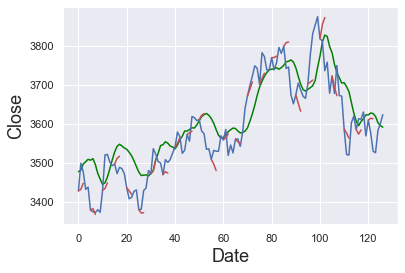

In [87]:
if __name__ == '__main__':
    # 参数
    days_num = 5
    epoch = 20
    fea = 5
    batch_size = 20
    early_stop = 5
    
    # 初始化模型
    model = CNNmodel()
    
    # 数据处理部分
    GD = GetData()
    train_x, test_x, train_y, test_y = GD.process_data()
    # print(x_train)
    x_train = torch.tensor(x_train).float()
    x_test = torch.tensor(x_test).float()
    y_train = torch.tensor(y_train).float()
    y_test = torch.tensor(y_test).float()
    train_data = TensorDataset(x_train, y_train)
    train_dataLoader = DataLoader(train_data, batch_size=batch_size)
    test_data = TensorDataset(x_test, y_test)
    test_dataLoader = DataLoader(test_data, batch_size=batch_size)

    
    # 损失函数和优化器
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(epoch, train_dataLoader, test_dataLoader)
    p, y, test_loss = test_model(test_dataLoader)
    
    # 画图
    pred = [ele * (GD.close_max - GD.close_min) + GD.close_min for ele in p]
    data = [ele * (GD.close_max - GD.close_min) + GD.close_min for ele in y]
    plot_img(data, pred)